In [26]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from windIO.yaml import load_yaml 

reading the results netcdf file

In [52]:
# dataset with hub height physical inputs
results_stacked=xr.load_dataset("results_stacked_hh.nc")

# dataset with vertical profile (with heights normalized by hub height)
results_stacked_heights=xr.load_dataset("results_stacked_fullprofile.nc")

In [53]:
results_stacked

<xarray.Dataset> Size: 191kB
Dimensions:                      (sample: 100, case_index: 182)
Coordinates:
  * sample                       (sample) float64 800B 0.0 1.0 2.0 ... 98.0 99.0
    k_b                          (sample) float64 800B 0.03502 ... 0.04703
    ss_alpha                     (sample) float64 800B 0.9133 1.014 ... 1.225
    wind_farm                    (case_index) <U31 23kB 'HR1' ... 'VirtWF_ABL...
    flow_case                    (case_index) float64 1kB 0.0 1.0 ... 14.0 15.0
Dimensions without coordinates: case_index
Data variables: (12/15)
    power_bias_perc              (sample, case_index) float64 146kB 7.945 ......
    wind_speed                   (case_index) float64 1kB 9.947 9.971 ... 12.97
    wind_direction               (case_index) float64 1kB 14.98 9.983 ... 270.0
    turbulence_intensity         (case_index) float64 1kB 0.0538 ... 0.03155
    potential_temperature        (case_index) float64 1kB 293.2 293.2 ... 293.2
    z0                           (case_index) float32 728B 0.00209 ... 0.0002
    ...                           ...
    capping_inversion_thickness  (case_index) float64 1kB 274.3 232.7 ... 295.1
    turb_rated_power             (case_index) float64 1kB 2e+06 ... 1.5e+07
    nt                           (case_index) int64 1kB 80 80 80 ... 100 100 100
    farm_density                 (case_index) float64 1kB 2.452e+05 ... 1.633...
    Blockage_Ratio               (case_index) float64 1kB 0.1439 ... 0.8986
    Blocking_Distance            (case_index) float64 1kB 1.6e+03 ... 1.852e+03

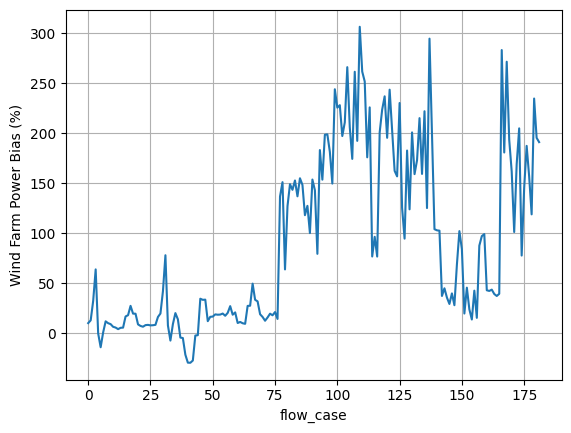

In [51]:
samplei=13

sample=results_stacked.k_b[samplei]

x=results_stacked.case_index.values
y=results_stacked.power_bias_perc.values[samplei,:]
plt.plot(x,y)
plt.xlabel('flow_case')
plt.ylabel('Wind Farm Power Bias (%)')
plt.grid()

Adding in blockage metrics

In [32]:
from utils import blockage_metrics
from pathlib import Path

In [33]:
case_i=results_stacked.case_index.values

BR_farms=[]
BD_farms=[]
for i in case_i:
    wind_farm=results_stacked.wind_farm.values[i]
    meta_file=f"EDF_datasets/{wind_farm}/meta.yaml"
    meta=load_yaml(Path(meta_file))
    dat = load_yaml(Path(f"EDF_datasets/{wind_farm}/{meta['system']}"))
 
    x=dat['wind_farm']['layouts'][0]['coordinates']['x']
    y=dat['wind_farm']['layouts'][0]['coordinates']['y']
    d=dat['wind_farm']['turbines']['rotor_diameter']

    xy = np.column_stack((x, y))

    wind_dir=results_stacked.wind_direction.values[i]

    BR, BD, BR_farm, BD_farm = blockage_metrics(xy, wind_dir, d)

    BR_farms.append(BR_farm)
    BD_farms.append(BD_farm)



In [34]:
results_stacked["Blockage_Ratio"] = xr.DataArray(BR_farms, dims=["case_index"])
results_stacked["Blocking_Distance"] = xr.DataArray(BD_farms, dims=["case_index"])

In [35]:
results_stacked.to_netcdf('results_stacked_hh.nc')